In [90]:
import os
import pytz, datetime, time
import json
import numpy as np
import pandas as pd
import base64, urllib2, json, requests
import pymysql.cursors
from sys import platform
import time, datetime
import matplotlib.pyplot as plt
from IPython.display import display    

def occpancy_stats():
    
    with open('data/Temperature_Occupancy_Meters.json') as k:
        rooms = json.load(k,encoding='latin1')
    
    if platform == 'linux' or platform == 'linux2':
        sock = "/var/run/mysqld/mysqld.sock"
    if platform == 'darwin':
        sock = "/tmp/mysql.sock"

    connection = pymysql.connect(host='localhost',
                                 user='root',
                                 password='',
                                 db='smart_energy',
                                 unix_socket = sock,
                                 cursorclass=pymysql.cursors.DictCursor)
    cursorObject = connection.cursor()
    
    start_date = ["2017-04-01","2017-05-01","2017-06-01"]
    end_date = ["2017-04-30","2017-05-31","2017-06-30"]
    room_names = ["A510","A515","A522","A523","A526","A527","A529"]

    st = " 00:00:00"
    et = " 23:59:00"
    
    
    # implement dictionary for NodeId to MeterId
    month_names = ['April','May','June']
    months = {}
    ts_counter = []
    d = ''
    for m in range(3):
        rooms_dict = {}
        for room_name in room_names: 
            for room in rooms:
                if room['RoomName'] == room_name:
                    break
            
            sd = datetime.datetime.strptime(start_date[m], "%Y-%m-%d")
            ed = datetime.datetime.strptime(end_date[m], "%Y-%m-%d")
            
            hourly_occupancy = []
            while sd <= ed:
                for node in room['RoomNodes']:
                    node_id = str(node['NodeId'])
                    for meter in node['OccupancyMeters']:
                        meter_id = str(meter['MeterId'])
                        query = "SELECT time " \
                                "FROM t_"+node_id+" " \
                                "WHERE (time > \""+sd.strftime("%Y-%m-%d")+st+"\") " \
                                "AND (time < \""+sd.strftime("%Y-%m-%d")+et+"\") " \
                                "AND (c_"+meter_id+" = 1)"

                        cursorObject.execute(query)
                        rows = cursorObject.fetchall()
                        if len(rows) > 0:
                            #print len(rows)
                            temp = [str(x['time']) for x in rows]
                            ts_counter = list(set().union(ts_counter, temp))
                
                hourly_occupancy.append(len(ts_counter)/12.0)
                sd = sd + datetime.timedelta(hours=24)
                ts_counter = []
                
            rooms_dict[room_name] = hourly_occupancy
            
        months[month_names[m]] = rooms_dict
    return months
    
months = occpancy_stats()

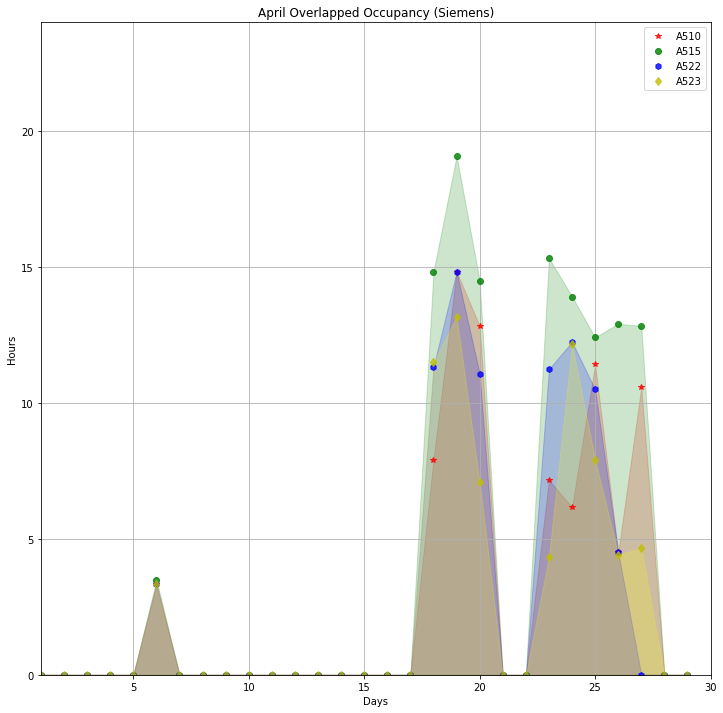

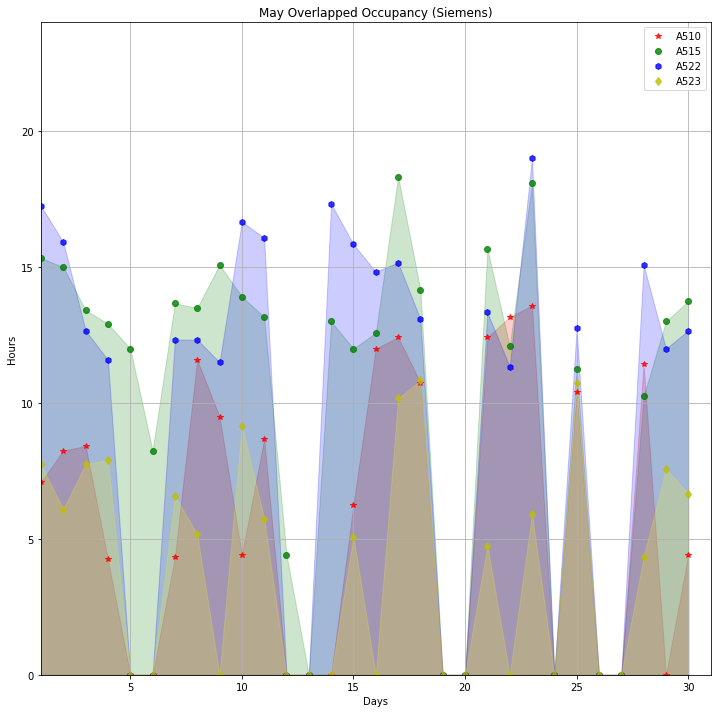

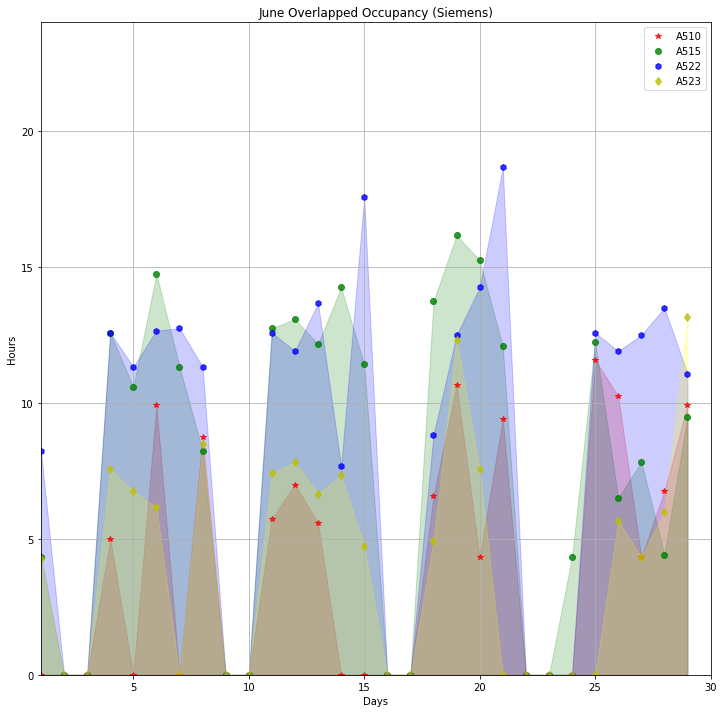

In [137]:
import scipy
mnth = ['April','May','June']
rooms = ["A510","A515","A522","A523"]#,"A526","A527","A529"]
colors = ['r','g','b','y','c','k','w']
marker = ['*','o','h','d','s','>','+']
color_names = ['red','green','blue','yellow','cyan','black','white']
for m in mnth:
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111)
    for i,r in enumerate(rooms):
        ax.set_xlim([1,len(months[m][r])])
        ax.set_ylim([0,24])
        ax.plot(months[m][r], colors[i]+marker[i], label= r, alpha=0.8)
        d = scipy.zeros(len(months[m][r]))
        X = [x for x in range(0,len(months[m][r]))]
        ax.fill_between(X,d,months[m][r], interpolate=True, color=color_names[i], alpha=0.2)
        ax.legend(loc='best')
        ax.set_xlabel('Days')
        ax.set_ylabel('Hours')
        
    plt.title(m+" Overlapped Occupancy (Siemens)")
    plt.grid()
plt.show()


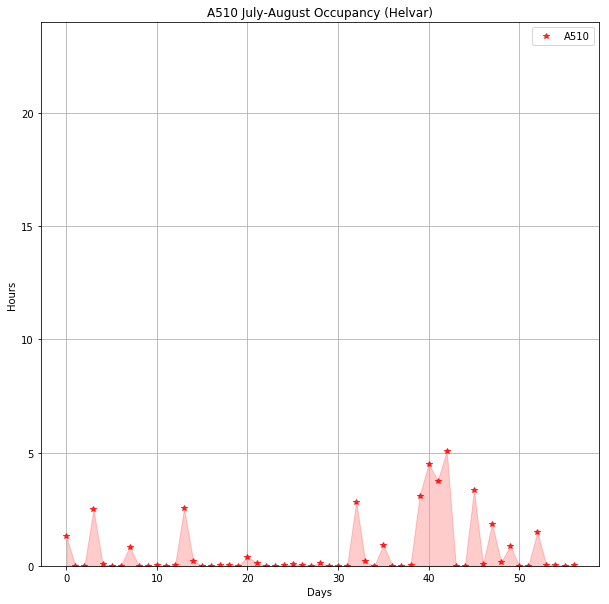

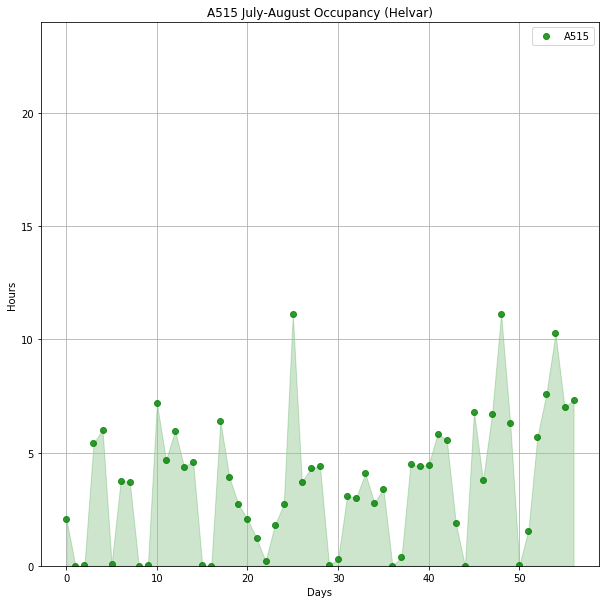

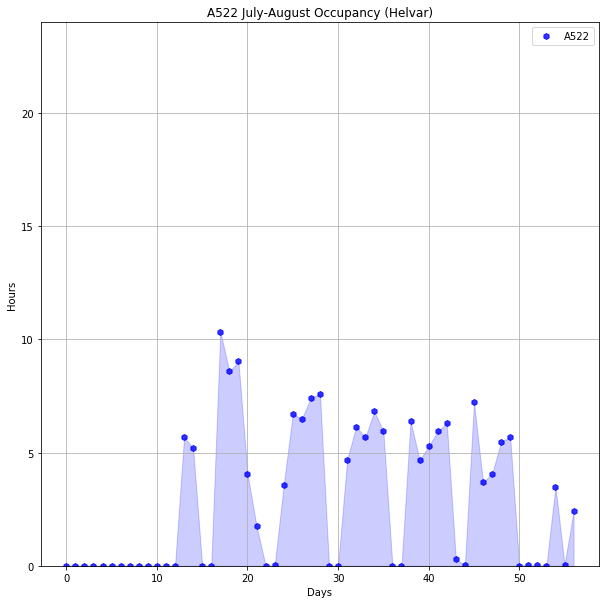

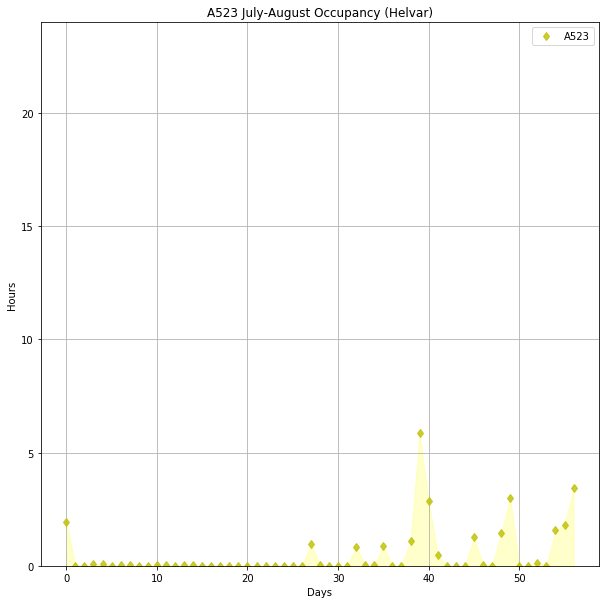

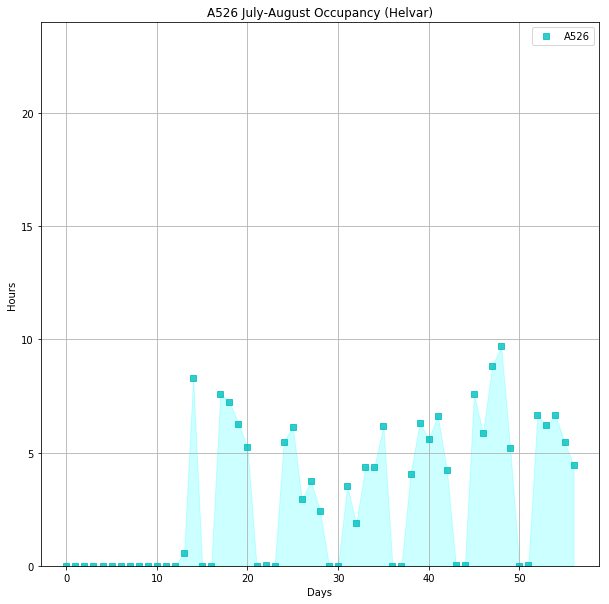

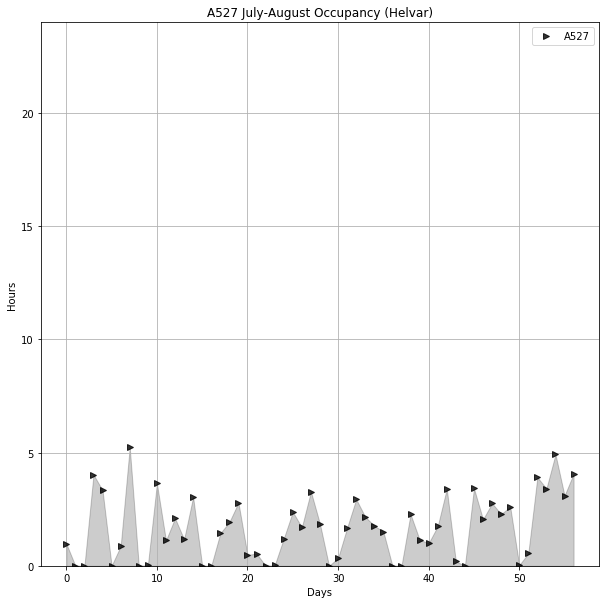

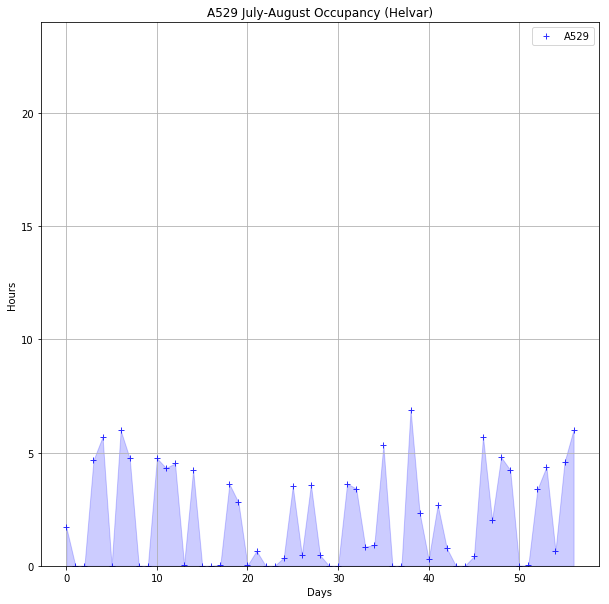

In [155]:
rooms = ["A510","A515","A522","A523","A526","A527","A529"]
colors = ['r','g','b','y','c','k','b']
marker = ['*','o','h','d','s','>','+']
color_names = ['red','green','blue','yellow','cyan','black','blue']

for i,r in enumerate(rooms):
    with open('data/UsageRate/'+r+'.txt') as k:
        temp = json.load(k,encoding='latin1')

    temperature = [float(t['Usage']) for t in reversed(temp)]

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    #ax.set_xlim([1,len(months[m][r])])
    ax.set_ylim([0,24])
    ax.plot(temperature, colors[i]+marker[i], label= r, alpha=0.8)
    d = scipy.zeros(len(temperature))
    X = [x for x in range(0,len(temperature))]
    ax.fill_between(X,d,temperature, interpolate=True, color=color_names[i], alpha=0.2)
    ax.legend(loc='best')
    ax.set_xlabel('Days')
    ax.set_ylabel('Hours')
        
    plt.title(r+" July-August Occupancy (Helvar)")
    plt.grid()
plt.show()

    

In [151]:
import scipy
mnth = ['April','May','June']
rooms = ["A510","A515","A522","A523"]#,"A526","A527","A529"]
colors = ['r','g','b','y','c','k','w']
marker = ['*','o','h','d','s','>','+']
color_names = ['red','green','blue','yellow','cyan','black','white']
for m in mnth:
    for i,r in enumerate(rooms):
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111)
        ax.set_xlim([1,len(months[m][r])])
        ax.set_ylim([0,24])
        ax.plot(months[m][r], colors[i]+marker[i], label= r, alpha=0.8)
        d = scipy.zeros(len(months[m][r]))
        X = [x for x in range(0,len(months[m][r]))]
        ax.fill_between(X,d,months[m][r], interpolate=True, color=color_names[i], alpha=0.2)
        ax.legend(loc='best')
        ax.set_xlabel('Days')
        ax.set_ylabel('Hours')
        
        plt.title(r+" "+m+" Occupancy (Siemens)")
        plt.grid()
        #plt.show()


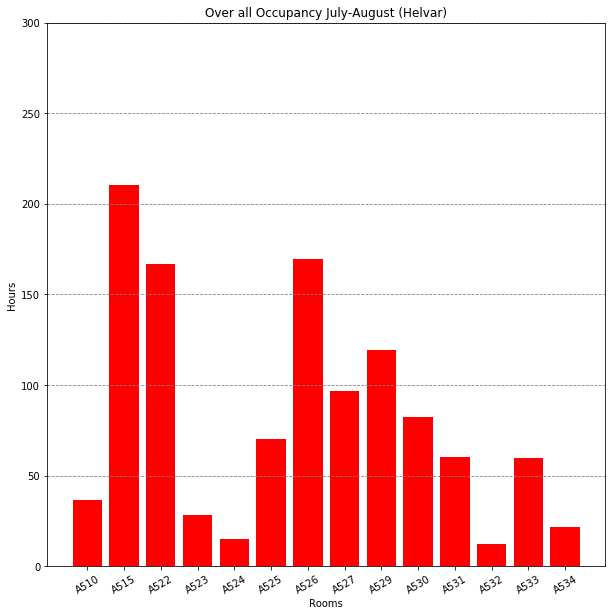

In [159]:
rooms = ["A510","A515","A522","A523","A524","A525","A526","A527","A529","A530","A531","A532","A533","A534"]
hour = []

for i,r in enumerate(rooms):
    with open('data/UsageRate/'+r+'.txt') as k:
        temp = json.load(k,encoding='latin1')

    hour.append(sum([float(t['Usage']) for t in reversed(temp)]))
    
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_ylim([0,300])
ax.bar(range(len(rooms)), hour, width=0.8, color='r')
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.legend(loc='best')
ax.set_xlabel('Rooms')
ax.set_ylabel('Hours')
#ax.set_xticks([x for x in range(len(rooms))]+0.4)

#ax.set_xticklabels(rooms)
plt.xticks(range(0,14), rooms, rotation=30)        
plt.title("Over all Occupancy July-August (Helvar)")
plt.show()

In [ ]:
room_names = ["A510","A515","A522","A523","A526","A527","A529"]
colors = ['r','g','b','y','c','k','b']
marker = ['*','o','h','d','s','>','+']
color_names = ['red','green','blue','yellow','cyan','black','blue']

with open('data/Temperature_Occupancy_Meters.json') as k:
    rooms = json.load(k,encoding='latin1')

if platform == 'linux' or platform == 'linux2':
    sock = "/var/run/mysqld/mysqld.sock"
if platform == 'darwin':
    sock = "/tmp/mysql.sock"

connection = pymysql.connect(host='localhost',
                             user='root',
                             password='',
                             db='smart_energy',
                             unix_socket = sock,
                             cursorclass=pymysql.cursors.DictCursor)
cursorObject = connection.cursor()

start_date = "2017-07-01"
end_date = "2017-07-25"


st = " 00:00:00"
et = " 23:59:00"

ts_counter = []
d = ''

for room_name in room_names: 
    for room in rooms:
        if room['RoomName'] == room_name:
            break

    sd = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    ed = datetime.datetime.strptime(end_date, "%Y-%m-%d")

    hourly_occupancy = []
    while sd <= ed:
        for node in room['RoomNodes']:
            node_id = str(node['NodeId'])
            for meter in node['OccupancyMeters']:
                meter_id = str(meter['MeterId'])
                query = "SELECT time " \
                        "FROM t_"+node_id+" " \
                        "WHERE (time > \""+sd.strftime("%Y-%m-%d")+st+"\") " \
                        "AND (time < \""+sd.strftime("%Y-%m-%d")+et+"\") " \
                        "AND (c_"+meter_id+" = 1)"

                cursorObject.execute(query)
                rows = cursorObject.fetchall()
                if len(rows) > 0:
                    #print len(rows)
                    temp = [str(x['time']) for x in rows]
                    ts_counter = list(set().union(ts_counter, temp))
        
        hourly_occupancy.append(len(ts_counter)/12.0)
        sd = sd + datetime.timedelta(hours=24)
        ts_counter = []



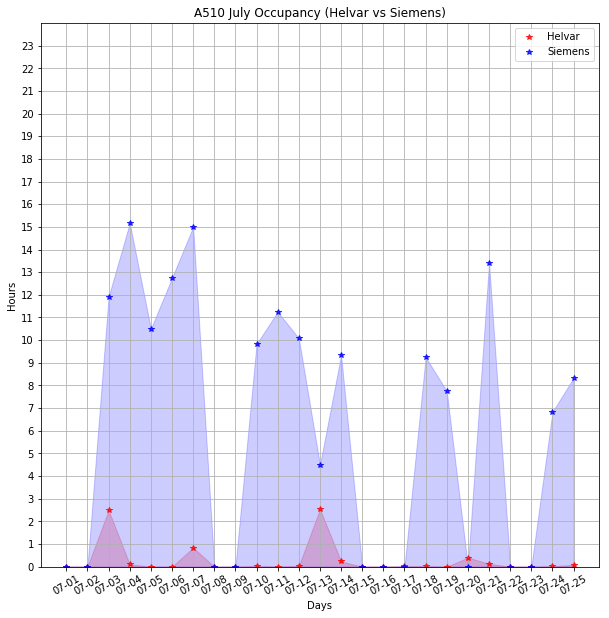

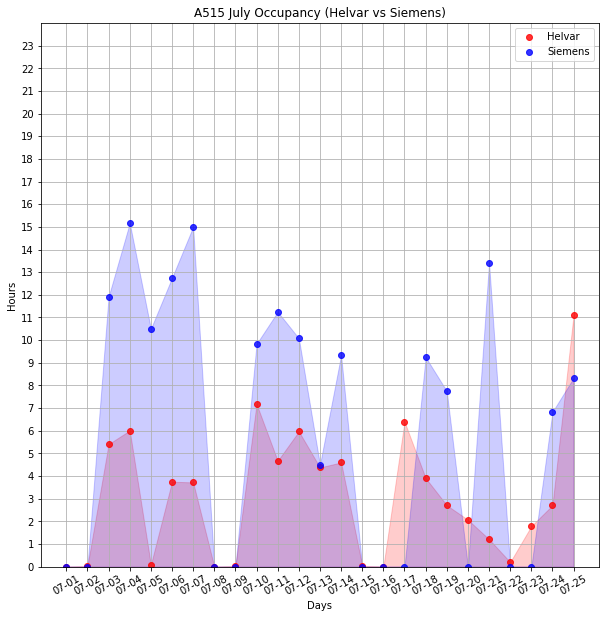

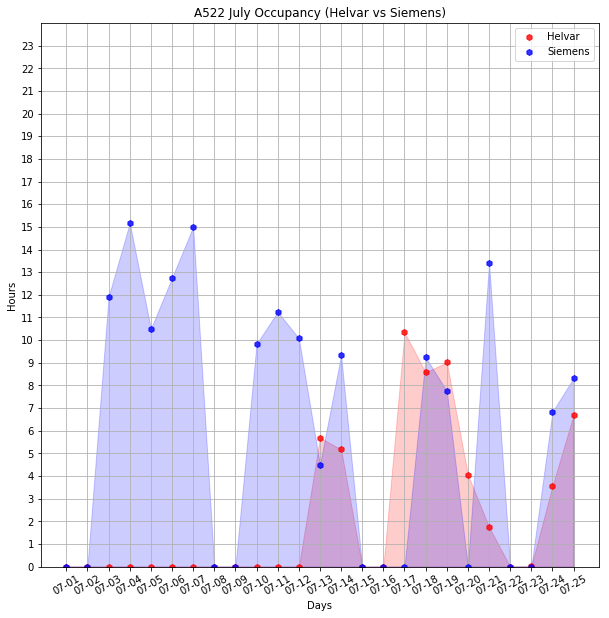

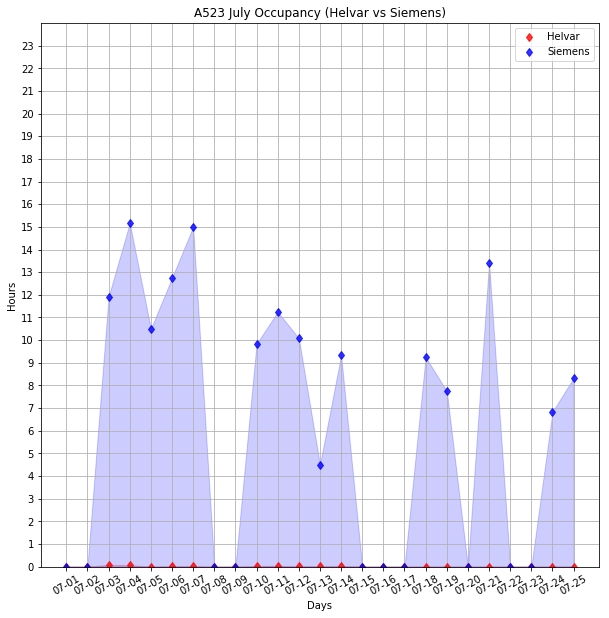

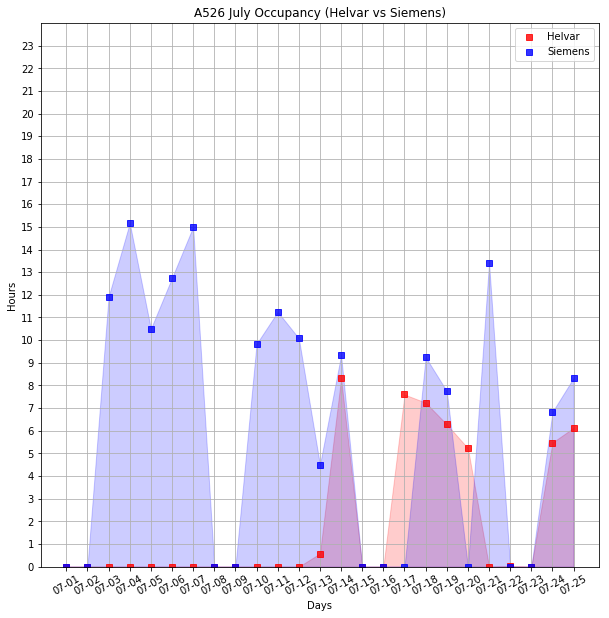

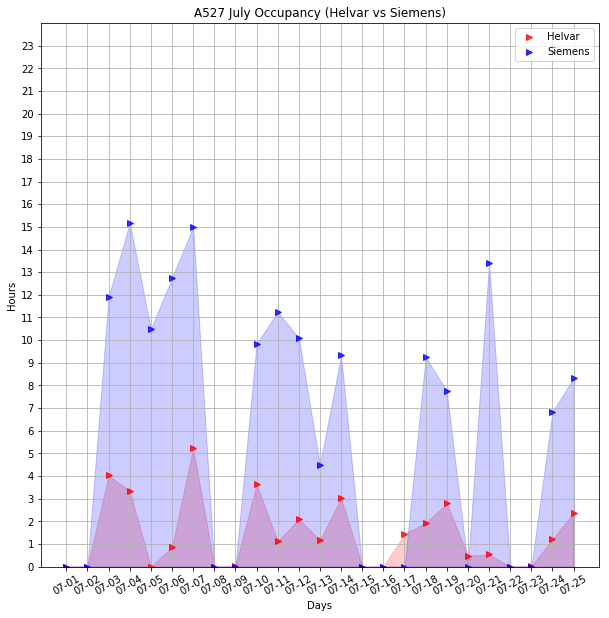

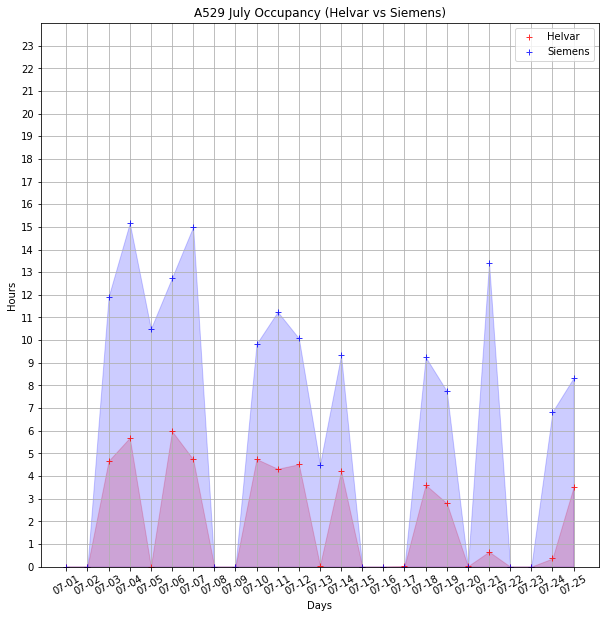

In [150]:
sd = datetime.datetime.strptime('2017/07/01', "%Y/%m/%d")
date_labels = [(sd+datetime.timedelta(hours=24*i)).strftime("%m-%d") for i in range(25)]

for i,r in enumerate(room_names):
    with open('data/UsageRate/'+r+'.txt') as k:
        temp = json.load(k,encoding='latin1')

    sd = datetime.datetime.strptime('2017/07/01', "%Y/%m/%d")
    ed = datetime.datetime.strptime('2017/07/25', "%Y/%m/%d")
    hour = [float(t['Usage']) for t in reversed(temp) 
                   if  datetime.datetime.strptime(t['Day'], "%Y/%m/%d") <= ed
                   and datetime.datetime.strptime(t['Day'], "%Y/%m/%d") >= sd
             ]
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.set_ylim([0,24])
    ax.plot(hour, 'r'+marker[i], label= 'Helvar', alpha=0.8)
    d = scipy.zeros(len(hour))
    X = [x for x in range(0,len(hour))]
    ax.fill_between(X,d,hour, interpolate=True, color='red', alpha=0.2)
    
    ax.plot(hourly_occupancy, 'b'+marker[i], label= 'Siemens', alpha=0.8)
    X = [x for x in range(0,len(hourly_occupancy))]
    ax.fill_between(X,d,hourly_occupancy, interpolate=True, color='blue', alpha=0.2)
    
    ax.legend(loc='best')
    ax.set_xlabel('Days')
    ax.set_ylabel('Hours')
    
    
    plt.title(r+" July Occupancy (Helvar vs Siemens)")
    plt.grid()
    plt.xticks(range(0,25), date_labels, rotation=30)
    plt.yticks(range(0,24), [x for x in range(24) ])
plt.show()

    